In [1]:
import os
import dask.dataframe as dd
import soundfile as sf
import numpy as np
import pandas as pd
from dask import delayed
import librosa
import librosa.display
import noisereduce as nr
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
import speech_recognition as sr

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
dev_clean_dir = r"D:\Rishi Documents and Data\Capstone Project - Speech to Text to Sign Language\Final_Audio_Dataset_25000"

In [3]:
# Function to extract features from audio files
def extract_features(file_path):
  data, samplerate = sf.read(file_path)
  mean_signal = np.mean(data)
  return pd.DataFrame({'file_path': [file_path], 'mean_signal': [mean_signal]})

In [4]:
# Function to reduce noise in audio
def reduce_noise(y, sr):
  return nr.reduce_noise(y=y, sr=sr)

In [5]:
# Function to aggregate audio data
def aggregate_audio_data(directory):
  mfccs_list = []
  chroma_list = []
  zcr_list = []
  durations = []
  centroid_list = []
  bandwidth_list = []

  for folder, _, files in os.walk(directory):
    for file in files:
      if file.endswith(".flac"):
        file_path = os.path.join(folder, file)
        y, sr = librosa.load(file_path)

        # Reduce noise
        y = reduce_noise(y, sr)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_list.append(mfccs_mean)

        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_list.append(chroma_mean)

        # Extract zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_list.append(zcr_mean)

        # Extract spectral centroid
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        centroid_mean = np.mean(centroid)
        centroid_list.append(centroid_mean)

        # Extract spectral bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_list.append(bandwidth_mean)

        # Extract duration
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)

  # Converting to DataFrame
  data = pd.DataFrame(mfccs_list, columns=[f'MFCC{i+1}' for i in range(13)])
  data[['Chroma' + str(i+1) for i in range(12)]] = pd.DataFrame(chroma_list)
  data['Zero Crossing Rate'] = zcr_list
  data['Duration'] = durations
  data['Spectral Centroid'] = centroid_list
  data['Spectral Bandwidth'] = bandwidth_list

  return data

In [6]:
# Function to visualize data
def visualize_data(data):
  print("Summary statistics of MFCCs:")
  print(data.iloc[:, :13].describe())
  print()

  plt.figure(figsize=(10, 8))
  sns.heatmap(data.iloc[:, :13].corr(), annot=True,fmt='.2f', cmap='coolwarm')
  plt.title('Correlation Heatmap of MFCCs')
  plt.show()

  plt.figure(figsize=(12, 6))
  data.iloc[:, :13].boxplot()
  plt.title('Boxplots of MFCCs')
  plt.xlabel('MFCC Coefficients')
  plt.ylabel('Values')
  plt.show()

  plt.figure(figsize=(12, 6))
  data.iloc[:, 13:25].boxplot()
  plt.title('Boxplots of Chroma Features')
  plt.xlabel('Chroma Features')
  plt.ylabel('Values')
  plt.show()

  plt.figure(figsize=(8, 6))
  plt.hist(data['Zero Crossing Rate'], bins=20,color='skyblue', edgecolor='black')
  plt.title('Histogram of Zero Crossing Rate')
  plt.xlabel('Zero Crossing Rate')
  plt.ylabel('Frequency')
  plt.show()

  plt.figure(figsize=(8, 6))
  plt.hist(data['Duration'], bins=20, color='skyblue',edgecolor='black')
  plt.title('Histogram of Audio Durations')
  plt.xlabel('Duration (seconds)')
  plt.ylabel('Frequency')
  plt.show()

  plt.figure(figsize=(8, 6))
  plt.hist(data['Spectral Centroid'], bins=20, color='skyblue', edgecolor='black')
  plt.title('Histogram of Spectral Centroid')
  plt.xlabel('Spectral Centroid')
  plt.ylabel('Frequency')
  plt.show()

  plt.figure(figsize=(8, 6))
  plt.hist(data['Spectral Bandwidth'], bins=20, color='skyblue', edgecolor='black')
  plt.title('Histogram of Spectral Bandwidth')
  plt.xlabel('Spectral Bandwidth')
  plt.ylabel('Frequency')
  plt.show()

In [7]:
# Load data and preprocess
audio_data = aggregate_audio_data(dev_clean_dir)

In [8]:
# Getting a glimpse of the data - MFCC coefficients, Chroma Features, Spectral Bandwidth, Spectral Centroid, Duration, Zero Crossing Rate
audio_data.head(5)

,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,...,Chroma7,Chroma8,Chroma9,Chroma10,Chroma11,Chroma12,Zero Crossing Rate,Duration,Spectral Centroid,Spectral Bandwidth
0,-538.036255,84.853241,-4.164584,15.917459,-2.224296,-8.303665,-17.790384,-21.168802,-19.567507,-8.814341,...,0.242614,0.288635,0.319687,0.318287,0.297345,0.303357,0.140659,14.340000,1719.035351,950.689701
1,-569.061584,58.750671,-3.308123,12.576245,2.671778,-4.518902,-11.433702,-13.181439,-10.695546,-3.259475,...,0.275982,0.293938,0.358497,0.348014,0.342197,0.325971,0.126764,13.510023,1692.014702,882.435343
2,-537.174561,74.982620,0.389278,14.093317,-9.888600,-8.920296,-16.702633,-23.259109,-18.522339,-9.891399,...,0.241787,0.296507,0.296051,0.306091,0.306427,0.326392,0.146661,14.440000,1870.306906,759.246603
3,-547.332703,87.542946,5.821174,19.991205,-8.334598,-5.903004,-18.524677,-24.518682,-17.834177,-11.866611,...,0.218390,0.270622,0.298180,0.345784,0.337429,0.320564,0.125462,14.860000,1601.532359,755.387455
4,-549.229858,79.573242,-2.020039,9.625884,-3.928555,-5.295460,-14.484434,-24.526941,-18.352837,-8.299105,...,0.192539,0.270667,0.336821,0.331035,0.305158,0.315816,0.134674,14.890023,1682.541103,779.944719


Summary statistics of MFCCs:
              MFCC1         MFCC2         MFCC3         MFCC4         MFCC5  \
count  25100.000000  25100.000000  25100.000000  25100.000000  25100.000000   
mean    -590.560791     69.396072      2.117280     23.059704      0.196415   
std       74.873619     13.686014      9.543553      8.935060      7.508471   
min     -869.379150     21.367647    -75.307114    -15.422985    -51.943470   
25%     -640.794510     60.585995     -3.239235     17.338799     -4.707762   
50%     -584.647797     68.799648      3.002536     22.864708      0.706657   
75%     -535.197571     77.298658      8.619358     28.402327      5.357170   
max     -247.277344    175.991592     43.854607     85.053505     37.796440   

              MFCC6         MFCC7         MFCC8         MFCC9        MFCC10  \
count  25100.000000  25100.000000  25100.000000  25100.000000  25100.000000   
mean       1.010415    -11.819768     -7.497697    -12.141726     -5.730544   
std        7.223273   

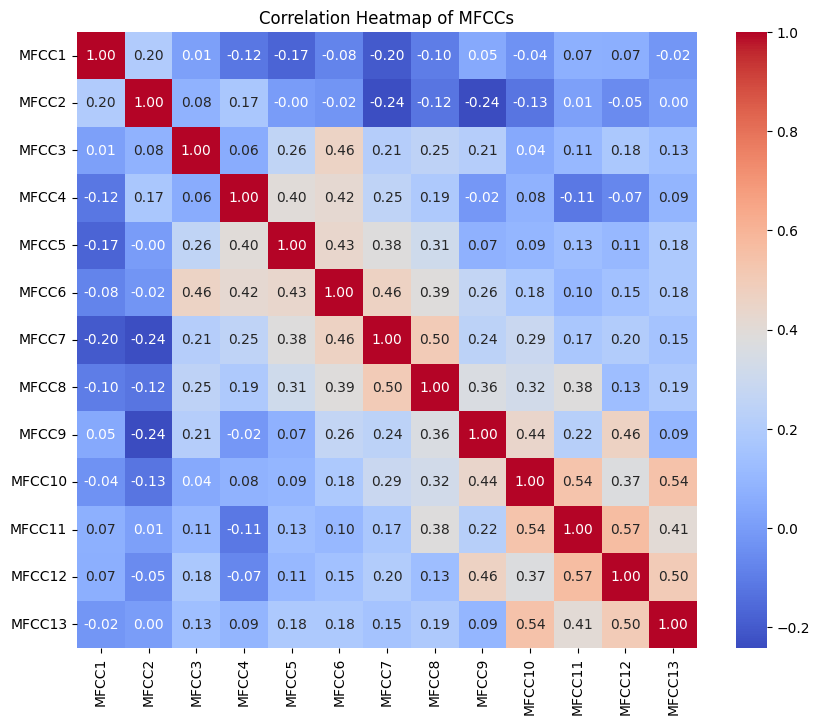

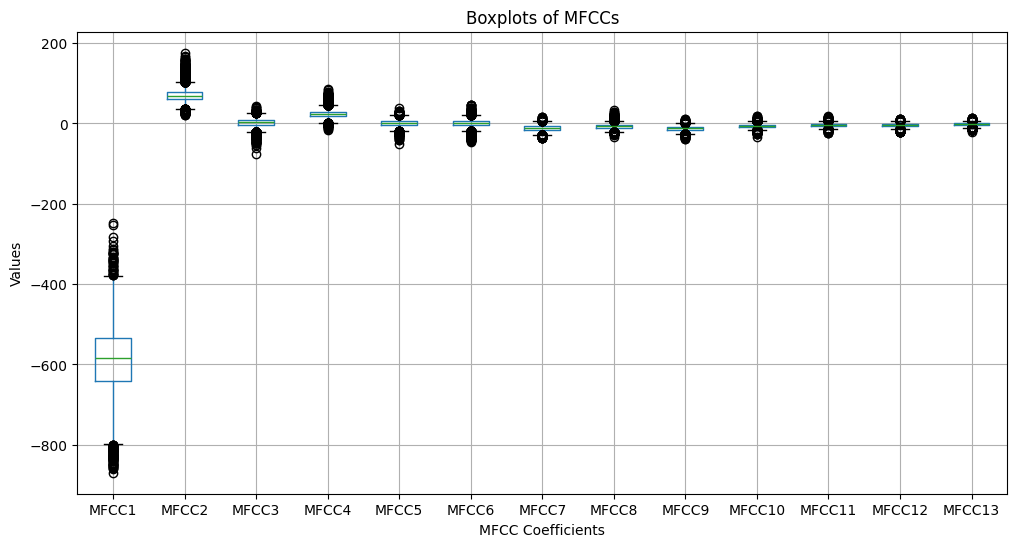

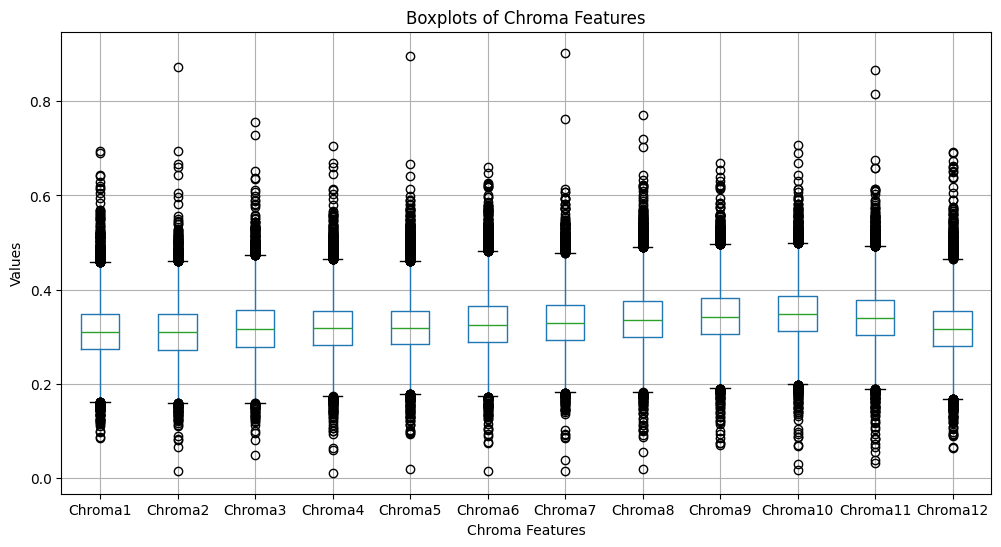

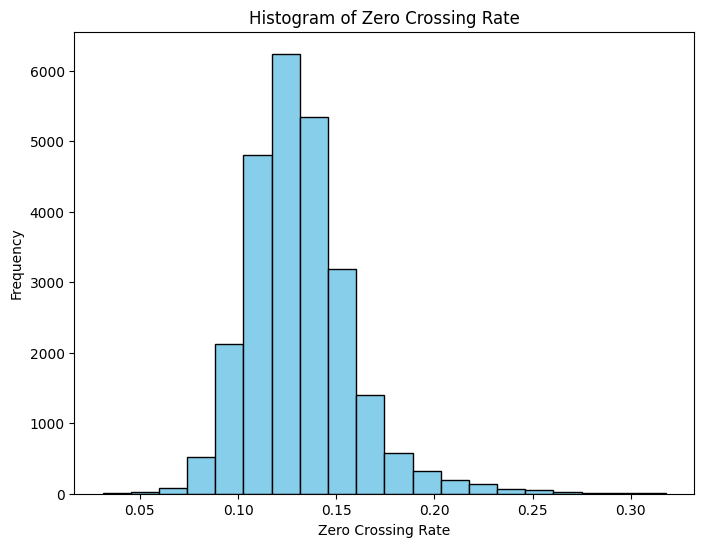

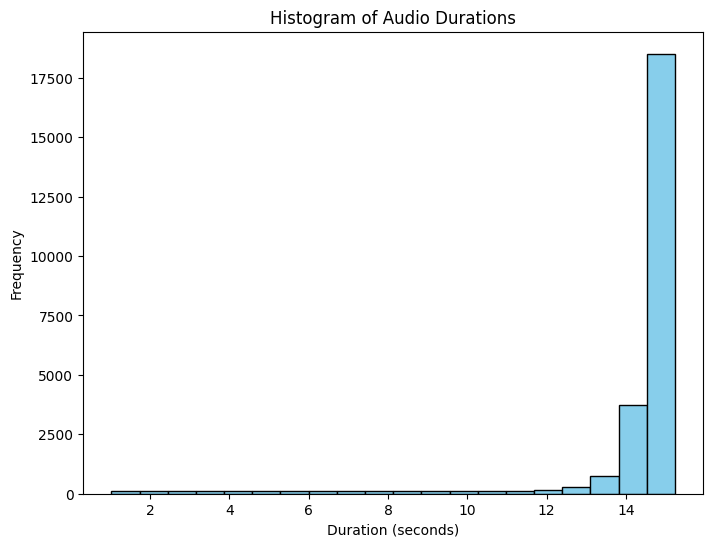

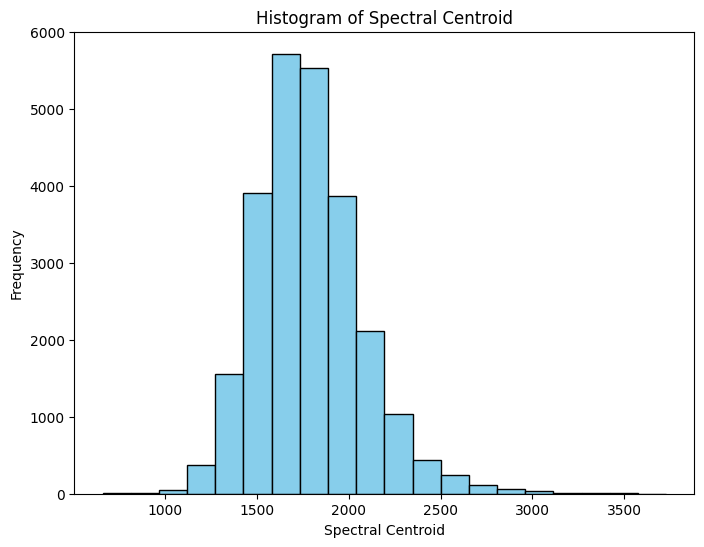

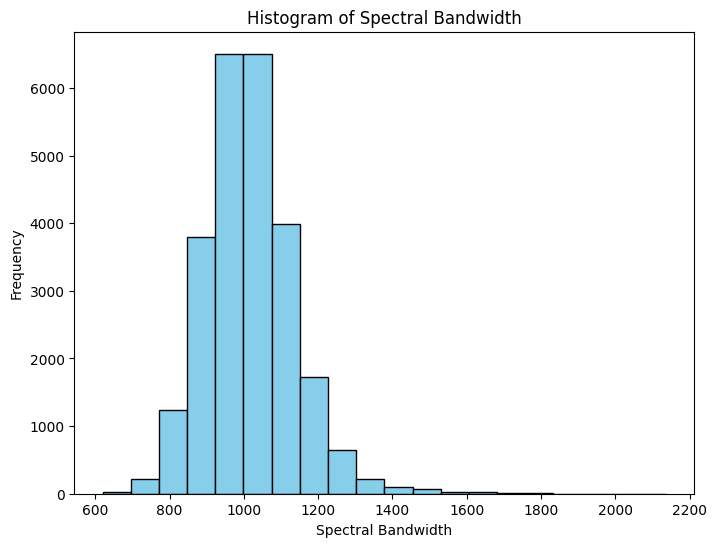

In [9]:
# Visualizing the data
visualize_data(audio_data)

# **Speech Recognition System**

In [10]:
# Function to Transcribe Audio from respective flac file
def transcribe_audio_from_file(audio_file):
  recognizer = sr.Recognizer()

  with sr.AudioFile(audio_file) as source:
    audio_data = recognizer.record(source)
  try:
    transcript = recognizer.recognize_google(audio_data, language="en-US")
    return transcript
  except sr.UnknownValueError:
    print("Google Web Speech API could not understand the audio")
    return None
  except sr.RequestError as e:
    print(f"Could not request results from Google Web Speech API; {e}")
    return None

In [ ]:
# Mapping the Audio Files and their transcript
def load_data(dev_clean_dir):
  audio_files = []
  transcripts = []

  for count, filename in enumerate(os.listdir(dev_clean_dir)):
    print("Processing File Number-",count+1)
    if filename.endswith('.flac'):
      file_path = os.path.join(dev_clean_dir, filename)
      audio_files.append(file_path)
      try:
          # Assuming you have a function to get transcripts from filename or another source
          transcript = transcribe_audio_from_file(file_path)
          transcripts.append(transcript)
      except sf.LibsndfileError as e:
          print(f"Error reading {file_path}: {e}")
      except IncompleteRead as e:
          print(f"Incomplete read for {file_path}: {e}")
      except Exception as e:
          print(f"An unexpected error occurred with {file_path}: {e}")

  return audio_files, transcripts

audio_files, transcripts = load_data(dev_clean_dir)

Processing File Number- 1
Processing File Number- 2
Processing File Number- 3
Processing File Number- 4
Google Web Speech API could not understand the audio
Processing File Number- 5
Google Web Speech API could not understand the audio
Processing File Number- 6
Google Web Speech API could not understand the audio
Processing File Number- 7
Processing File Number- 8
Google Web Speech API could not understand the audio
Processing File Number- 9
Processing File Number- 10
Google Web Speech API could not understand the audio
Processing File Number- 11
Processing File Number- 12
Google Web Speech API could not understand the audio
Processing File Number- 13
Google Web Speech API could not understand the audio
Processing File Number- 14
Processing File Number- 15
Google Web Speech API could not understand the audio
Processing File Number- 16
Processing File Number- 17
Processing File Number- 18
Processing File Number- 19
Processing File Number- 20
Processing File Number- 21
Processing File Nu

In [33]:
# Pairing Audio Files with Transcripts
labeled_data = [(audio_files[i], transcripts[i]) for i in range(len(audio_files))]

In [35]:
# Use a tokenizer to convert transcriptions (text) into sequences of integers that the model can process.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
# Filter out None values
transcripts = [t for t in transcripts if t is not None]

In [43]:
# Initialize the Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(transcripts)

In [44]:
# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(transcripts)

In [46]:
# Pad sequences to ensure uniform length
max_seq_len = max(len(seq) for seq in sequences)
y = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

In [49]:
# Check if the lengths match
if len(audio_data) != len(y):
    print(f"Mismatch in number of samples: audio_data ({len(audio_data)}) and transcripts ({len(y)})")

Mismatch in number of samples: audio_data (15000) and transcripts (13125)


In [50]:
# Assuming we need to truncate or pad the smaller dataset
min_len = min(len(audio_data), len(y))
audio_data = audio_data[:min_len]
y = y[:min_len]

In [51]:
# Now the lengths should match
print(f"After adjustment: audio_data ({len(audio_data)}) and transcripts ({len(y)})")

After adjustment: audio_data (13125) and transcripts (13125)


In [52]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(audio_data, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Prepare decoder input data (shifted target sequences for teacher-forcing)
decoder_input_train = np.zeros_like(y_train)
decoder_input_train[:, 1:] = y_train[:, :-1]
decoder_input_val = np.zeros_like(y_val)
decoder_input_val[:, 1:] = y_val[:, :-1]
decoder_input_test = np.zeros_like(y_test)
decoder_input_test[:, 1:] = y_test[:, :-1]

# Expand target data for sparse categorical crossentropy
decoder_target_train = np.expand_dims(y_train, -1)
decoder_target_val = np.expand_dims(y_val, -1)
decoder_target_test = np.expand_dims(y_test, -1)

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Reshape X_train to be 3D: (num_samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=-1)

# Define the model architecture
def define_model(input_shape, output_vocab_size):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

# Check the reshaped shape
print(f"X_train reshaped shape: {X_train_reshaped.shape}")

# Define the model
model = define_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), output_vocab_size=len(tokenizer.word_index) + 1)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

X_train reshaped shape: (9187, 29, 1)


In [76]:
# Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 256)         │          12,800 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ [(None, 256), (None,      │         264,192 │ input_layer_6[0][0]        │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ [(None, None, 256),       │         525,312 │ embedding_1[0][0],         │
│                               │ (None, 256), (None, 256)] │                 │ lstm_4[0][1], lstm_4[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, None, 50)          │          12,850 │ lstm_5[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 815,154 (3.11 MB)

 Trainable params: 815,154 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training if val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  

history = model.fit(
    [X_train_reshaped, decoder_input_train],
    decoder_target_train,
    batch_size=64,
    epochs=100,
    validation_data=([X_val, decoder_input_val], decoder_target_val),callbacks=[early_stopping]
)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8319 - loss: 0.5483 - val_accuracy: 0.8302 - val_loss: 0.5554
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8315 - loss: 0.5486 - val_accuracy: 0.8308 - val_loss: 0.5533
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8321 - loss: 0.5463 - val_accuracy: 0.8311 - val_loss: 0.5515
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8326 - loss: 0.5447 - val_accuracy: 0.8315 - val_loss: 0.5495
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8336 - loss: 0.5406 - val_accuracy: 0.8322 - val_loss: 0.5476
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8349 - loss: 0.5357 - val_accuracy: 0.8326 - val_loss: 0.5461
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8360 - loss: 0.5320 - val_accuracy: 0.8327 - val_loss: 0.5448
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8363 - loss: 0.5304 - 

In [102]:
# Get training and validation loss and accuracy from history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Train Loss: {train_loss[-1]}, Final Train Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}, Final Validation Accuracy: {val_accuracy[-1]}")

Final Train Loss: 0.49387404322624207, Final Train Accuracy: 0.846616268157959
Final Validation Loss: 0.5307028889656067, Final Validation Accuracy: 0.8375977277755737


In [103]:
test_loss, test_accuracy = model.evaluate([X_test, decoder_input_test], decoder_target_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.8352 - loss: 0.5404
Test Loss: 0.5385490655899048, Test Accuracy: 0.83604496717453


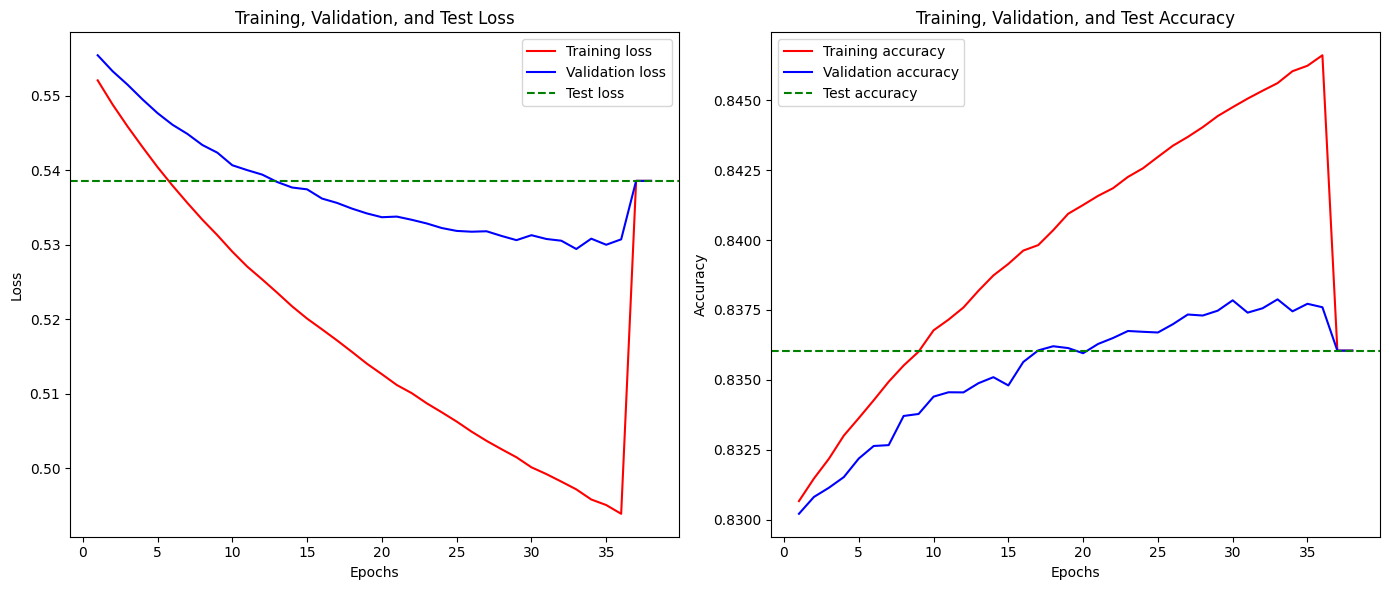

In [107]:
# Append the final test loss and accuracy to the end of the respective lists for plotting
train_loss.append(test_loss)
val_loss.append(test_loss)
train_accuracy.append(test_accuracy)
val_accuracy.append(test_accuracy)

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting the Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig('training_validation_test_metrics.png')
plt.show()

In [111]:
# Generate predictions for the test set
y_pred = model.predict([X_test, decoder_input_test])

62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step


In [112]:
# Define a function to convert sequences to text
def sequences_to_texts(sequences, tokenizer):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    texts = []
    for seq in sequences:
        words = [reverse_word_map.get(i, '') for i in seq]
        texts.append(' '.join(words))
    return texts

# Convert predictions and ground truth to text
y_pred_texts = sequences_to_texts(y_pred.argmax(axis=-1), tokenizer)
y_true_texts = sequences_to_texts(y_test, tokenizer)

In [113]:
from jiwer import wer, cer

# Calculate WER and CER
wer_score = wer(y_true_texts, y_pred_texts)
cer_score = cer(y_true_texts, y_pred_texts)

print(f"Word Error Rate (WER): {wer_score}")
print(f"Character Error Rate (CER): {cer_score}")

Word Error Rate (WER): 0.4144991973277305
Character Error Rate (CER): 0.17337556207233626
